In [12]:
from dt_apriltags import Detector
import cv2
import matplotlib.pyplot as plt
import numpy as np
from pid import *
import numpy as np
from math import isclose
#import apriltaghelper as at

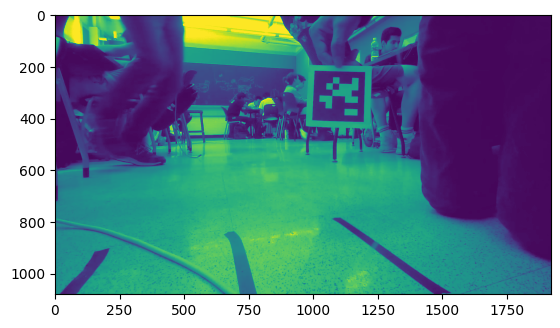

In [13]:
cap = cv2.VideoCapture('AprilTagTest.mkv')
ret, frame = cap.read()

gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

plt.imshow(gray)

In [14]:
cameraMatrix = np.array([ 1060.71, 0, 960, 0, 1060.71, 540, 0, 0, 1]).reshape((3,3))

camera_params = ( cameraMatrix[0,0], cameraMatrix[1,1], cameraMatrix[0,2], cameraMatrix[1,2] )

Tag:  1
(1096.567978083538, 316.6836764538464)
(52716.66865255535, -80886.12627143854)
(52716.66865255535, -80886.12627143854)


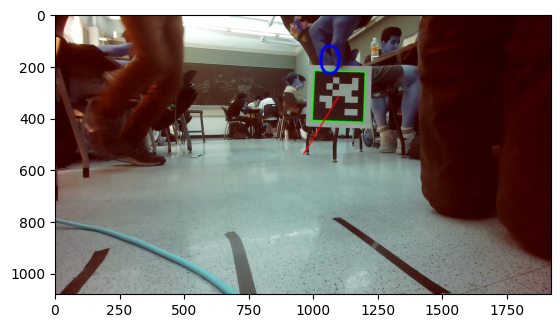

Tag:  1
(1124.6282604153141, 423.6420884829822)
(64601.07573829826, -42400.23017866949)
(64601.07573829826, -42400.23017866949)


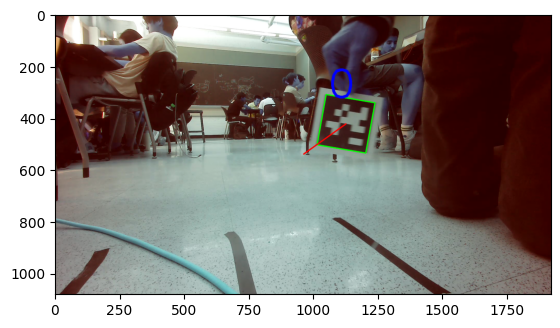

Tag:  1
(840.8931524956985, 244.29556322224732)
(-47661.01081730654, -110994.9459571879)
(-47661.01081730654, -110994.9459571879)


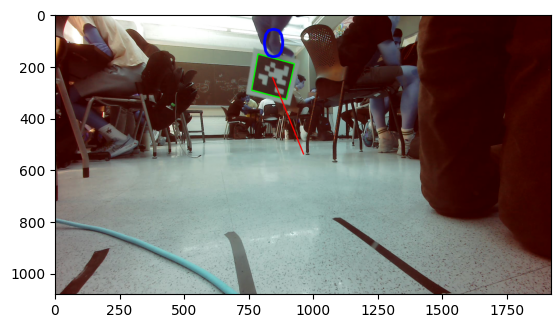

In [21]:
vcap = cv2.VideoCapture("AprilTagTest.mkv")

width = int(vcap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(vcap.get(cv2.CAP_PROP_FRAME_HEIGHT))

output_file = 'april_tags.avi'
fourcc = cv2.VideoWriter_fourcc(*'XVID')
output_video = cv2.VideoWriter(output_file, fourcc, 30, (width, height))

frequency = 100
count = 0

while True:
    ret, img = vcap.read()
    if not ret:
        try:
            print("Final output: ", (x_output, y_output))
            break
        except:
            print("PID was not activated")
            break

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)


    if count % frequency == 0:
        #print(img.shape[0], img.shape[1]) #rows, columns
        at_detector = Detector(families='tag36h11',
                    nthreads=1,
                    quad_decimate=1.0,
                    quad_sigma=0.0,
                    refine_edges=1,
                    decode_sharpening=0.25,
                    debug=0)
        cameraMatrix = np.array([ 1060.71, 0, 960, 0, 1060.71, 540, 0, 0, 1]).reshape((3,3))
        camera_params = ( cameraMatrix[0,0], cameraMatrix[1,1], cameraMatrix[0,2], cameraMatrix[1,2] )
        tags = at_detector.detect(gray, True, camera_params, tag_size  = 0.1)
        color_img = img


        depth_pid = PID(1, 0.0, 0.5, 100)
        x_pid = PID(1, 0.0, 0.5, 100)

        i=1
        for tag in tags:
            print("Tag: ", i)
            center_x = sum(coord[0] for coord in tag.corners) / 4
            center_y = sum(coord[1] for coord in tag.corners) / 4
            for idx in range(len(tag.corners)):
                cv2.line(color_img, tuple(tag.corners[idx - 1, :].astype(int)), tuple(tag.corners[idx, :].astype(int)), (0, 255, 0), 3)

            cv2.putText(color_img, str(tag.tag_id),
                        org=(tag.corners[0, 0].astype(int) + 10, tag.corners[0, 1].astype(int) + 10),
                        fontFace=cv2.FONT_HERSHEY_SIMPLEX,
                        fontScale=5,
                        color=(0, 0, 255),
                        thickness =  10)
            i+=1
            #depth
            print((tag.center[0], tag.center[1]))

            cv2.line(color_img, tuple(map(int, tag.center)), tuple(map(int, np.array(img.shape[1::-1])/2)), (255, 0, 0), 3) 

            #displaced_x = tag.pose_t[0][0]
            displaced_x = tag.center[0] - (img.shape[1]/2)
            #print(displaced_x)
            #displaced_depth = tag.pose_t[1][0]
            displaced_y = tag.center[1] - (img.shape[0]/2)
            #print(displaced_y)

            x_output = 0
            y_output = 0

            #while(not isclose(x_output, tag.center[0]) and not isclose(y_output, tag.center[1])):
            displaced_x = tag.center[0] - (img.shape[1]/2)
            x_output = x_pid.update(displaced_x)
            displaced_y = tag.center[1] - (img.shape[0]/2)
            y_output = depth_pid.update(displaced_y)
            print((x_output, y_output))

            #at.set_vertical_power(y_output)
            #at.set_lateral_power(x_output)

            
            print((x_output, y_output))

            
        plt.imshow(color_img)
        plt.show()

    count += 1